<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled252.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyscf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.m3d import Axes3D  # noqa: F401

import gemmi
from pyscf import gto, dft
from pyscf.dft import numint

# =========================================
# 1. Load 6LK1 and collect Fe/S atoms
# =========================================

cif_path = "6LK1.cif"  # ensure this exists

doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in 6LK1")

# =========================================
# 2. Cluster Fe/S atoms (distance-based)
# =========================================

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited(nb):
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# =========================================
# 3. Pick cluster 1 (2Fe + 6S) and centre it
# =========================================

cluster_idx = 1   # change to 5 if you want the other 2Fe–6S
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

# =========================================
# 4. One-shot PBE SCF and curvature PDF
# =========================================

def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for (s, (x, y, z)) in zip(symbols, coords)]
    atom_str = "\n".join(atom_lines)

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
        return np.array([]), mf, mol
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)

# create a "vibrationally enhanced" curvature by scaling
delta = 0.15  # 15% effective curvature increase
kappa_vib = (1.0 + delta) * kappa_base

# =========================================
# 5. HOMO cloud for base, and scaled coordinates for "vib" visual
# =========================================

def homo_cloud(mol, mf,
               box=3.0,
               ngrid=32,
               keep_percent=97.0,
               max_points=4000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
# mimic breathing by scaling coordinates of the cloud (keep ψ values)
coords_cloud_vib = coords_cloud_base * (1.0 + delta)
psi_cloud_vib    = psi_cloud_base   # same amplitudes, just moved in space

# =========================================
# 6. Plot: geometry, PDFs, clouds
# =========================================

fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z + 0.3, sym, ha='center', fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i] - coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster (6LK1, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)

# (b) Curvature PDFs base vs "vibrated"
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col in [(kappa_base, "base", "tab:blue"),
                      (kappa_vib,  f"scaled x{1+delta:.2f}", "tab:red")]:
    counts, edges = np.histogram(arr, bins=50, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.plot(centers, counts, color=col, label=lab)
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title("Fe–S curvature PDF\n(base vs 'breathing' proxy)")
ax2.legend()

# (c) HOMO clouds base vs vibrated
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
cols_base = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_base, alpha=0.5, label="base")
cols_vib = np.where(psi_cloud_vib >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_vib[:,0],
            coords_cloud_vib[:,1],
            coords_cloud_vib[:,2],
            s=4, c=cols_vib, alpha=0.5, label="breathing")
for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z + 0.3, sym, ha='center', fontsize=8)
ax3.set_title("Fe–S HOMO cloud\n(base vs 'breathing' displacement)")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)
ax3.legend(loc="upper right")

plt.tight_layout()
plt.savefig("fes_6lk1_breathing_proxy.png", dpi=300)
plt.show()
print("Saved: fes_6lk1_breathing_proxy.png")

SyntaxError: unterminated string literal (detected at line 237) (ipython-input-3249028376.py, line 237)

In [ ]:
!pip install gemmi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.1 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 17.2 MB/s eta 0:00:00
Found 25 Fe/S atoms in 6LK1
Found 10 Fe/S-connected clusters
  Cluster 0: 1 atoms (0 Fe, 1 S)
  Cluster 1: 8 atoms (2 Fe, 6 S)
  Cluster 2: 2 atoms (0 Fe, 2 S)
  Cluster 3: 1 atoms (0 Fe, 1 S)
  Cluster 4: 1 atoms (0 Fe, 1 S)
  Cluster 5: 8 atoms (2 Fe, 6 S)
  Cluster 6: 1 atoms (0 Fe, 1 S)
  Cluster 7: 1 atoms (0 Fe, 1 S)
  Cluster 8: 1 atoms (0 Fe, 1 S)
  Cluster 9: 1 atoms (0 Fe, 1 S)

Using cluster 1 with atoms:
  1: S, (7.713, -7.272, 22.924)
  15: Fe, (5.508, -6.531, 22.895)
  18: S, (4.997, -6.752, 20.748)
  17: S, (5.095, -4.352, 23.250)
  16: Fe, (4.734, -4.618, 21.086)
  6: S, (6.225, -3.665, 19.642)
  3: S, (2.676, -3.882, 20.430)
  2: S, (4.379, -7.793, 24.419)
SCF not converged.
SCF energy = -4841.12716205779


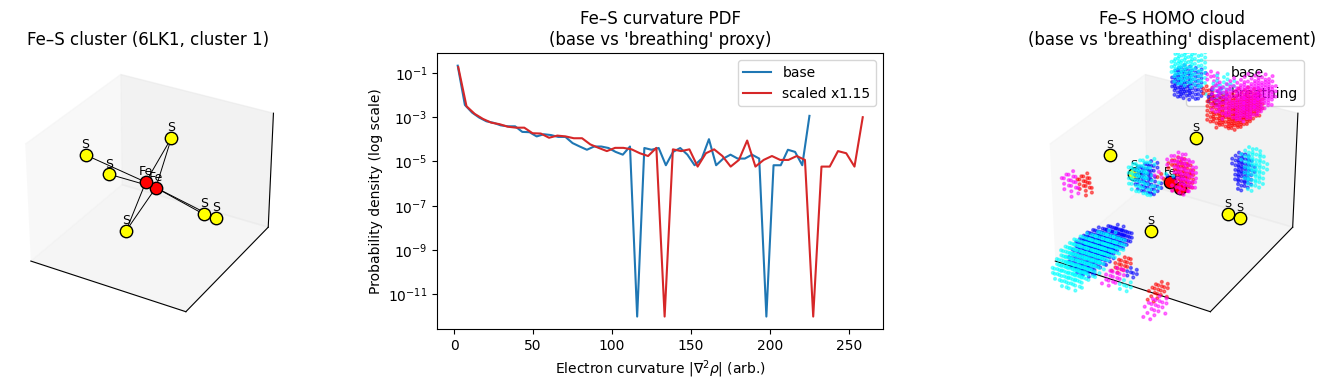

Saved: fes_6lk1_breathing_proxy.png


In [ ]:
!pip install -q pyscf gemmi

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import gemmi
from pyscf import gto, dft
from pyscf.dft import numint

# =========================================
# 1. Load 6LK1 and collect Fe/S atoms
# =========================================

cif_path = "6LK1.cif"  # ensure this exists

doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in 6LK1")

# =========================================
# 2. Cluster Fe/S atoms (distance-based)
# =========================================

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# =========================================
# 3. Pick cluster 1 (2Fe + 6S) and centre it
# =========================================

cluster_idx = 1   # change to 5 if you want the other 2Fe–6S
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

# =========================================
# 4. One-shot PBE SCF and curvature PDF
# =========================================

def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for (s, (x, y, z)) in zip(symbols, coords)]
    atom_str = "\n".join(atom_lines)

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
        return np.array([]), mf, mol
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)

# create a "vibrationally enhanced" curvature by scaling
delta = 0.15  # 15% effective curvature increase
kappa_vib = (1.0 + delta) * kappa_base

# =========================================
# 5. HOMO cloud for base, and scaled coordinates for "vib" visual
# =========================================

def homo_cloud(mol, mf,
               box=3.0,
               ngrid=32,
               keep_percent=97.0,
               max_points=4000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
# mimic breathing by scaling coordinates of the cloud (keep ψ values)
coords_cloud_vib = coords_cloud_base * (1.0 + delta)
psi_cloud_vib    = psi_cloud_base   # same amplitudes, just moved in space

# =========================================
# 6. Plot: geometry, PDFs, clouds
# =========================================

fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z + 0.3, sym, ha='center', fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i] - coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster (6LK1, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)

# (b) Curvature PDFs base vs "vibrated"
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col in [(kappa_base, "base", "tab:blue"),
                      (kappa_vib,  f"scaled x{1+delta:.2f}", "tab:red")]:
    counts, edges = np.histogram(arr, bins=50, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.plot(centers, counts, color=col, label=lab)
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title("Fe–S curvature PDF\n(base vs 'breathing' proxy)")
ax2.legend()

# (c) HOMO clouds base vs vibrated
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
cols_base = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_base, alpha=0.5, label="base")
cols_vib = np.where(psi_cloud_vib >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_vib[:,0],
            coords_cloud_vib[:,1],
            coords_cloud_vib[:,2],
            s=4, c=cols_vib, alpha=0.5, label="breathing")
for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z + 0.3, sym, ha='center', fontsize=8)
ax3.set_title("Fe–S HOMO cloud\n(base vs 'breathing' displacement)")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)
ax3.legend(loc="upper right")

plt.tight_layout()
plt.savefig("fes_6lk1_breathing_proxy.png", dpi=300)
plt.show()
print("Saved: fes_6lk1_breathing_proxy.png")

Found 25 Fe/S atoms in 6LK1
Found 10 Fe/S-connected clusters
  Cluster 0: 1 atoms (0 Fe, 1 S)
  Cluster 1: 8 atoms (2 Fe, 6 S)
  Cluster 2: 2 atoms (0 Fe, 2 S)
  Cluster 3: 1 atoms (0 Fe, 1 S)
  Cluster 4: 1 atoms (0 Fe, 1 S)
  Cluster 5: 8 atoms (2 Fe, 6 S)
  Cluster 6: 1 atoms (0 Fe, 1 S)
  Cluster 7: 1 atoms (0 Fe, 1 S)
  Cluster 8: 1 atoms (0 Fe, 1 S)
  Cluster 9: 1 atoms (0 Fe, 1 S)

Using cluster 5 with atoms:
  9: S, (-2.620, -7.364, 34.236)
  21: Fe, (-0.432, -6.608, 34.195)
  24: S, (0.136, -6.764, 36.332)
  23: S, (-0.053, -4.414, 33.770)
  22: Fe, (0.348, -4.624, 35.940)
  13: S, (-1.114, -3.655, 37.421)
  11: S, (2.422, -3.860, 36.524)
  10: S, (0.683, -7.903, 32.688)
SCF not converged.
SCF energy = -4839.31780098096


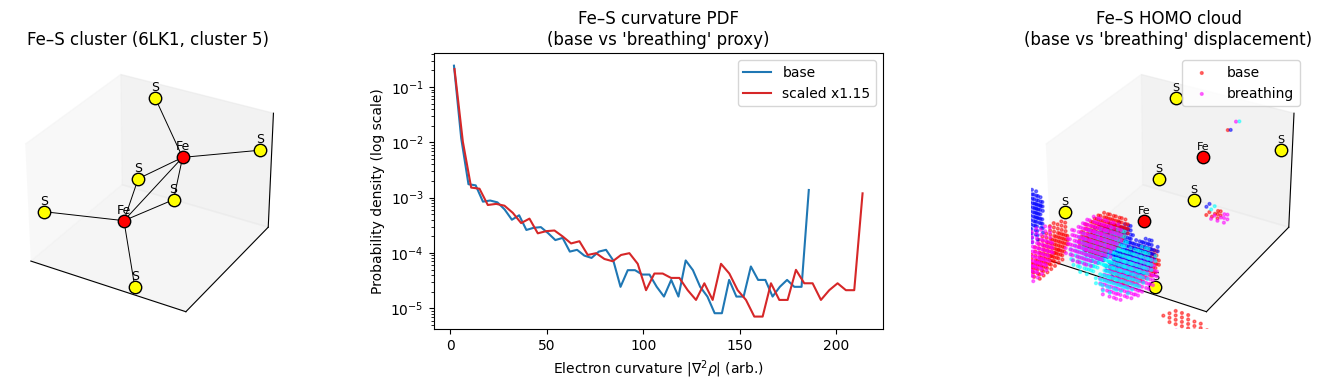

Saved: fes_6lk1_breathing_proxy.png


In [ ]:
!pip install -q pyscf gemmi

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import gemmi
from pyscf import gto, dft
from pyscf.dft import numint

# =========================================
# 1. Load 6LK1 and collect Fe/S atoms
# =========================================

cif_path = "6LK1.cif"  # ensure this exists

doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in 6LK1")

# =========================================
# 2. Cluster Fe/S atoms (distance-based)
# =========================================

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# =========================================
# 3. Pick cluster 1 (2Fe + 6S) and centre it
# =========================================

cluster_idx = 5   # change to 5 if you want the other 2Fe–6S
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

# =========================================
# 4. One-shot PBE SCF and curvature PDF
# =========================================

def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for (s, (x, y, z)) in zip(symbols, coords)]
    atom_str = "\n".join(atom_lines)

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
        return np.array([]), mf, mol
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)

# create a "vibrationally enhanced" curvature by scaling
delta = 0.15  # 15% effective curvature increase
kappa_vib = (1.0 + delta) * kappa_base

# =========================================
# 5. HOMO cloud for base, and scaled coordinates for "vib" visual
# =========================================

def homo_cloud(mol, mf,
               box=3.0,
               ngrid=32,
               keep_percent=97.0,
               max_points=4000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
# mimic breathing by scaling coordinates of the cloud (keep ψ values)
coords_cloud_vib = coords_cloud_base * (1.0 + delta)
psi_cloud_vib    = psi_cloud_base   # same amplitudes, just moved in space

# =========================================
# 6. Plot: geometry, PDFs, clouds
# =========================================

fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z + 0.3, sym, ha='center', fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i] - coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster (6LK1, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)

# (b) Curvature PDFs base vs "vibrated"
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col in [(kappa_base, "base", "tab:blue"),
                      (kappa_vib,  f"scaled x{1+delta:.2f}", "tab:red")]:
    counts, edges = np.histogram(arr, bins=50, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.plot(centers, counts, color=col, label=lab)
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title("Fe–S curvature PDF\n(base vs 'breathing' proxy)")
ax2.legend()

# (c) HOMO clouds base vs vibrated
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
cols_base = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_base, alpha=0.5, label="base")
cols_vib = np.where(psi_cloud_vib >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_vib[:,0],
            coords_cloud_vib[:,1],
            coords_cloud_vib[:,2],
            s=4, c=cols_vib, alpha=0.5, label="breathing")
for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z + 0.3, sym, ha='center', fontsize=8)
ax3.set_title("Fe–S HOMO cloud\n(base vs 'breathing' displacement)")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)
ax3.legend(loc="upper right")

plt.tight_layout()
plt.savefig("fes_6lk1_breathing_proxy.png", dpi=300)
plt.show()
print("Saved: fes_6lk1_breathing_proxy.png")

In [ ]:
import os
os.listdir()

['.config', '6LK1.cif', 'fes_6lk1_fe_s_stretch_mode.png', 'sample_data']

Found 25 Fe/S atoms in 6LK1.cif
Found 10 Fe/S-connected clusters
  Cluster 0: 1 atoms (0 Fe, 1 S)
  Cluster 1: 8 atoms (2 Fe, 6 S)
  Cluster 2: 2 atoms (0 Fe, 2 S)
  Cluster 3: 1 atoms (0 Fe, 1 S)
  Cluster 4: 1 atoms (0 Fe, 1 S)
  Cluster 5: 8 atoms (2 Fe, 6 S)
  Cluster 6: 1 atoms (0 Fe, 1 S)
  Cluster 7: 1 atoms (0 Fe, 1 S)
  Cluster 8: 1 atoms (0 Fe, 1 S)
  Cluster 9: 1 atoms (0 Fe, 1 S)

Using cluster 5 with atoms:
  9: S, (-2.620, -7.364, 34.236)
  21: Fe, (-0.432, -6.608, 34.195)
  24: S, (0.136, -6.764, 36.332)
  23: S, (-0.053, -4.414, 33.770)
  22: Fe, (0.348, -4.624, 35.940)
  13: S, (-1.114, -3.655, 37.421)
  11: S, (2.422, -3.860, 36.524)
  10: S, (0.683, -7.903, 32.688)
Fe indices in cluster: [1 4]
Bridging S candidates: [2 3]
SCF not converged.
SCF energy = -4848.83662890876
SCF not converged.
SCF energy = -4841.23402488929
Saved NPZ: 6LK1_cluster5_asymmetric_FeS_stretch_ModeB.npz  (617818 bytes)

Refined histogram/trough analysis:


,case,n_troughs,mean_trough_width,max_kappa,compression_%
0,base,2,15.385460,205.139468,0.000000
1,asymmetric_FeS_stretch_ModeB,3,14.754192,208.294477,1.537982


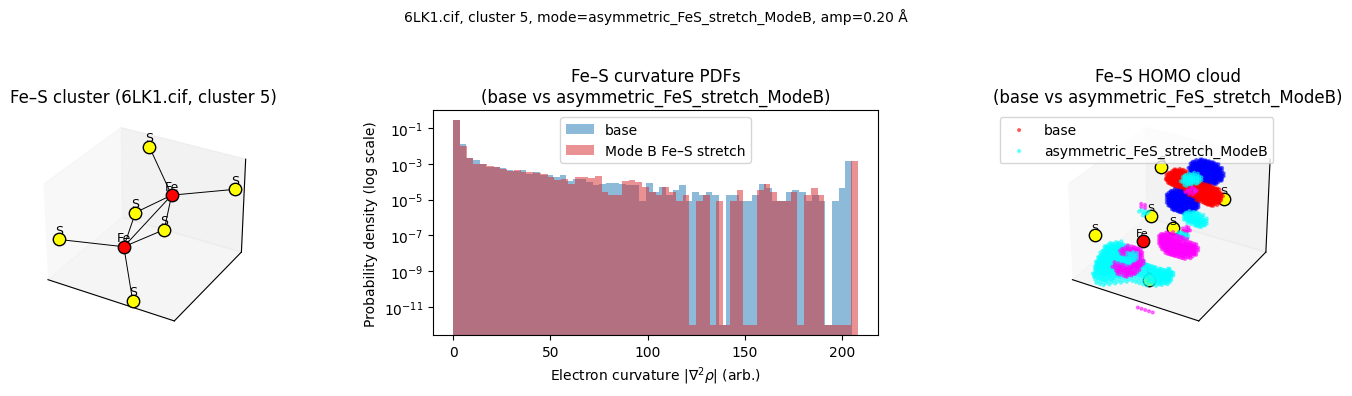

Saved PNG: 6LK1_cluster5_asymmetric_FeS_stretch_ModeB.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import os, sys, subprocess

# -----------------------------------------------------------------------------
# Ensure dependencies
# -----------------------------------------------------------------------------
def ensure_module(mod_name, pip_name=None):
    try:
        __import__(mod_name)
    except ImportError:
        if pip_name is None:
            pip_name = mod_name
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    finally:
        globals()[mod_name] = __import__(mod_name)

ensure_module("gemmi")
ensure_module("pyscf")

from pyscf import gto, dft
from pyscf.dft import numint

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------
cif_path    = "6LK1.cif"        # CIF file name
cluster_idx = 5                # 1 or 5 for your two Fe–S sites
mode_name   = "asymmetric_FeS_stretch_ModeB"
amp         = 0.20              # Å magnitude of Fe–S stretch
ngrid       = 32
box         = 3.0               # grid box half-length around cluster
rho_thresh  = 1e-3
out_tag     = f"{os.path.splitext(cif_path)[0]}_cluster{cluster_idx}_{mode_name}"

# -----------------------------------------------------------------------------
# 1. Load CIF and find Fe/S atoms
# -----------------------------------------------------------------------------
doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in {cif_path}")

# -----------------------------------------------------------------------------
# 2. Cluster Fe/S atoms by distance
# -----------------------------------------------------------------------------
def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# -----------------------------------------------------------------------------
# 3. Build centred Fe–S cluster
# -----------------------------------------------------------------------------
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

fe_indices = np.where(symbols == "Fe")[0]
s_indices  = np.where(symbols == "S")[0]
print("Fe indices in cluster:", fe_indices)

# pick two bridging S as closest to Fe–Fe midpoint
fe_mid = coords_centered[fe_indices].mean(axis=0)
s_dists = np.linalg.norm(coords_centered[s_indices] - fe_mid, axis=1)
order   = np.argsort(s_dists)
bridge_s = s_indices[order[:2]]
print("Bridging S candidates:", bridge_s)

# -----------------------------------------------------------------------------
# 4. Curvature PDF for a given geometry
# -----------------------------------------------------------------------------
def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_str = "\n".join(
        f"{s} {x:.6f} {y:.6f} {z:.6f}" for s,(x,y,z) in zip(symbols, coords)
    )

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 100
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(
    symbols, coords_centered, box=box, ngrid=ngrid, rho_thresh=rho_thresh
)

# -----------------------------------------------------------------------------
# 5. HOMO cloud helper
# -----------------------------------------------------------------------------
def homo_cloud(mol, mf,
               box=3.5,  # a bit larger to avoid clipping
               ngrid=36,
               keep_percent=97.0,
               max_points=6000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)

# -----------------------------------------------------------------------------
# 6. Mode B: Asymmetric Fe–S stretch
# -----------------------------------------------------------------------------
coords_stretched = coords_centered.copy()

def stretch_fe_s(coords, idx_fe, idx_s, delta):
    r_fe = coords[idx_fe]
    r_s  = coords[idx_s]
    v = r_s - r_fe
    d = np.linalg.norm(v)
    if d < 1e-6:
        return coords
    u = v / d
    coords[idx_fe] -= 0.5 * delta * u
    coords[idx_s]  += 0.5 * delta * u
    return coords

fe0, fe1 = fe_indices
s0,  s1  = bridge_s

coords_stretched = stretch_fe_s(coords_stretched, fe0, s0, +amp)
coords_stretched = stretch_fe_s(coords_stretched, fe1, s1, -amp)

# Curvature + HOMO for stretched geometry
kappa_mode, mf_mode, mol_mode = curvature_pdf_and_mf(
    symbols, coords_stretched, box=box, ngrid=ngrid, rho_thresh=rho_thresh
)
coords_cloud_mode, psi_cloud_mode = homo_cloud(mol_mode, mf_mode)

# -----------------------------------------------------------------------------
# 7. NPZ save
# -----------------------------------------------------------------------------
def save_npz_clean(filename, **kwargs):
    np.savez(filename, **kwargs)
    if os.path.exists(filename):
        print(f"Saved NPZ: {filename}  ({os.path.getsize(filename)} bytes)")
    else:
        print("❌ NPZ not saved")

npz_name = f"{out_tag}.npz"
save_npz_clean(
    npz_name,
    cif_path=cif_path,
    cluster_idx=cluster_idx,
    symbols=symbols,
    coords_base=coords_centered,
    coords_mode=coords_stretched,
    kappa_base=kappa_base,
    kappa_mode=kappa_mode,
    coords_cloud_base=coords_cloud_base,
    psi_cloud_base=psi_cloud_base,
    coords_cloud_mode=coords_cloud_mode,
    psi_cloud_mode=psi_cloud_mode,
    mode_name=mode_name,
    amp=amp
)
def histogram_stats(kappa, bins=60):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    eps = 1e-14
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def smooth_counts(counts, window=3):
    """Simple moving average to remove tiny jaggies."""
    kern = np.ones(window)/window
    return np.convolve(counts, kern, mode="same")

def trough_analysis_refined(centers, counts,
                            depth_factor=0.3,
                            min_bins=3):
    """
    Refined trough detection:
      - smooth counts
      - threshold = min + depth_factor*(median - min)
      - trough = contiguous bins below threshold
      - only keep troughs with width >= min_bins
    Returns: n_troughs, mean_width, widths list
    """
    c_sm = smooth_counts(counts, window=5)
    c_min = c_sm.min()
    c_med = np.median(c_sm)
    thr = c_min + depth_factor*(c_med - c_min)

    low = c_sm < thr

    trough_count = 0
    widths = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1
            if (end - start + 1) >= min_bins:
                trough_count += 1
                widths.append(centers[end] - centers[start])
        else:
            i += 1
    mean_width = np.mean(widths) if widths else 0.0
    return trough_count, mean_width, widths

# recompute histograms
centers_b, counts_b, edges_b = histogram_stats(kappa_base, bins=80)
centers_m, counts_m, edges_m = histogram_stats(kappa_mode, bins=80)

# refined trough metrics
n_trough_b, mean_w_b, widths_b = trough_analysis_refined(centers_b, counts_b,
                                                         depth_factor=0.3,
                                                         min_bins=3)
n_trough_m, mean_w_m, widths_m = trough_analysis_refined(centers_m, counts_m,
                                                         depth_factor=0.3,
                                                         min_bins=3)

max_kappa_b = kappa_base.max() if kappa_base.size else 0.0
max_kappa_m = kappa_mode.max() if kappa_mode.size else 0.0
compression = ((max_kappa_m - max_kappa_b)/max_kappa_b*100.0
               if max_kappa_b > 0 else 0.0)

import pandas as pd
table = pd.DataFrame({
    "case": ["base", mode_name],
    "n_troughs": [n_trough_b, n_trough_m],
    "mean_trough_width": [mean_w_b, mean_w_m],
    "max_kappa": [max_kappa_b, max_kappa_m],
    "compression_%": [0.0, compression],
})
print("\nRefined histogram/trough analysis:")
display(table)
# -----------------------------------------------------------------------------
# 9. Plot 3-panel figure (geometry, combs, clouds) and save 600 dpi PNG
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z+0.3, sym, ha="center", fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i]-coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)

ax1.set_title(f"Fe–S cluster ({os.path.basename(cif_path)}, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m-max_range/2, m+max_range/2)

# (b) curvature PDFs (hist combs)
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col, alpha in [
    (kappa_base, "base", "tab:blue", 0.5),
    (kappa_mode, "Mode B Fe–S stretch", "tab:red", 0.5),
]:
    counts, edges = np.histogram(arr, bins=60, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.bar(centers, counts, width=(edges[1]-edges[0]),
            color=col, alpha=alpha, label=lab)

ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title(f"Fe–S curvature PDFs\n(base vs {mode_name})")
ax2.legend()

# (c) HOMO clouds (larger box)
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
cols_b = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_b, alpha=0.5, label="base")
cols_m = np.where(psi_cloud_mode >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_mode[:,0],
            coords_cloud_mode[:,1],
            coords_cloud_mode[:,2],
            s=4, c=cols_m, alpha=0.5, label=mode_name)

for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z+0.3, sym, ha="center", fontsize=8)

ax3.set_title(f"Fe–S HOMO cloud\n(base vs {mode_name})")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])

# auto-scale to include cloud
all_cloud = np.vstack([coords_cloud_base, coords_cloud_mode])
cloud_max_range = (all_cloud.max(axis=0) - all_cloud.min(axis=0)).max()
cloud_mid = all_cloud.mean(axis=0)
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], cloud_mid):
    setter(m-cloud_max_range/2, m+cloud_max_range/2)

ax3.legend(loc="upper right")

# add annotation with CIF & mode info
fig.suptitle(
    f"{cif_path}, cluster {cluster_idx}, mode={mode_name}, amp={amp:.2f} Å",
    fontsize=10
)

plt.tight_layout(rect=[0,0,1,0.95])
png_name = f"{out_tag}.png"
plt.savefig(png_name, dpi=600)
plt.show()
print("Saved PNG:", png_name)

Loaded: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
Number of κ points: 32768


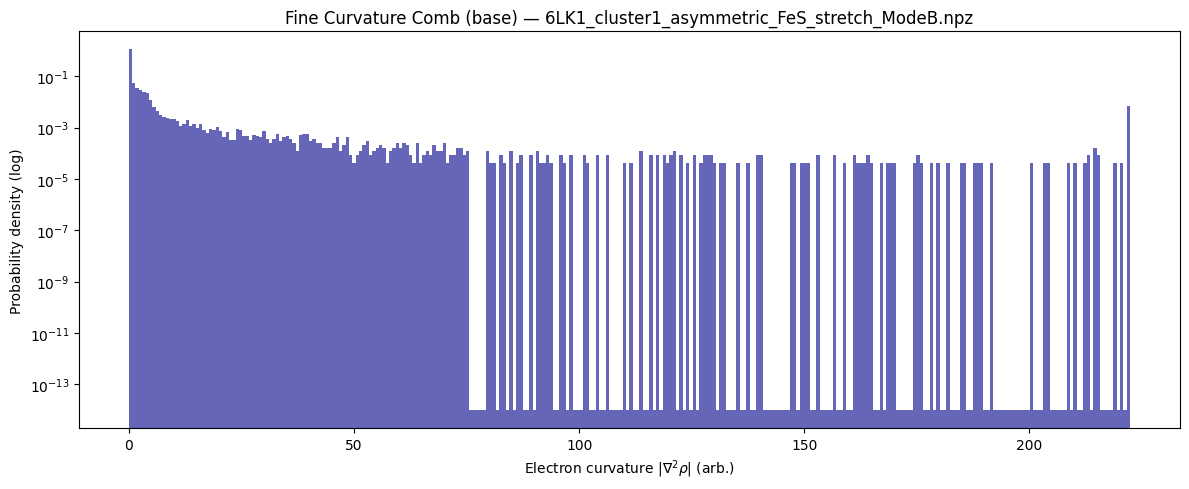

ValueError: x and y must have same first dimension, but have shapes (599,) and (300,)

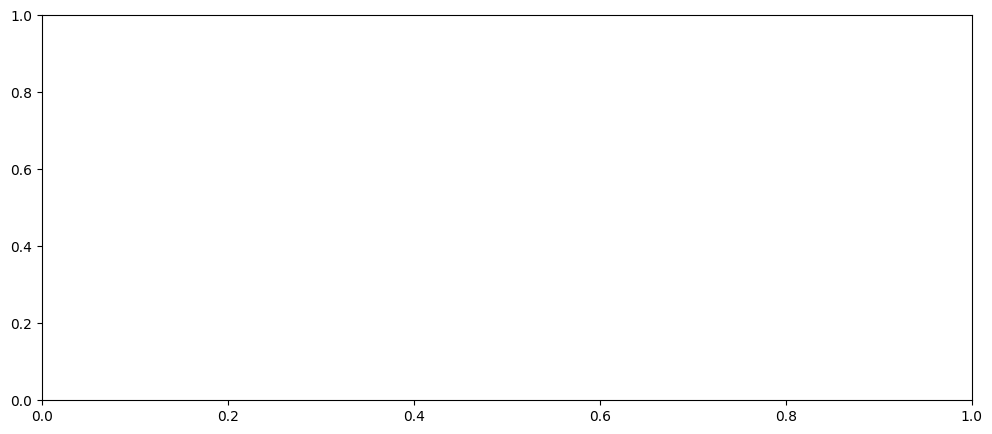

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.fft import rfft, rfftfreq

# -------------------------------------------------------------
# LOAD NPZ FILE
# Change this to cluster 1 or cluster 5 NPZ
# -------------------------------------------------------------
filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base = data["kappa_base"]

print("Loaded:", filename)
print("Number of κ points:", len(kappa_base))

# -------------------------------------------------------------
# 1. Fine histogram of curvature (fine-tooth comb)
# -------------------------------------------------------------
bins = 300  # SUPER FINE resolution
counts, edges = np.histogram(kappa_base, bins=bins, density=True)
centers = 0.5*(edges[:-1] + edges[1:])

eps = 1e-14
counts = np.maximum(counts, eps)

plt.figure(figsize=(12,5))
plt.bar(centers, counts, width=(edges[1]-edges[0]), color="darkblue", alpha=0.6)
plt.yscale("log")
plt.title(f"Fine Curvature Comb (base) — {filename}")
plt.xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
plt.ylabel("Probability density (log)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 2. Autocorrelation of histogram (reveals comb periodicity)
# -------------------------------------------------------------
auto = correlate(counts - np.mean(counts), counts - np.mean(counts), mode="full")
mid = len(auto)//2
lags = np.arange(-bins+1, bins)

plt.figure(figsize=(12,5))
plt.plot(lags, auto[mid:], color="purple")
plt.title(f"Autocorrelation of Curvature Comb (base) — {filename}")
plt.xlabel("Lag (bin index)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 3. FFT — Frequency-domain view of fine comb spacing
# -------------------------------------------------------------
freqs = rfftfreq(bins, d=1)
fft_vals = np.abs(rfft(counts - np.mean(counts)))

plt.figure(figsize=(12,5))
plt.plot(freqs, fft_vals, color="crimson")
plt.title(f"FFT of Curvature Comb — frequency of troughs/teeth ({filename})")
plt.xlabel("Frequency (1/bin)")
plt.ylabel("FFT amplitude")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4. Print simple metrics
# -------------------------------------------------------------
dominant_freq = freqs[np.argmax(fft_vals[1:])+1]
print("Dominant comb frequency:", dominant_freq)
print("Approximate trough spacing (bins):", 1/dominant_freq if dominant_freq!=0 else np.nan)